# Safety Filtering
```Author: Kensuke Nakamura```

```Acknowledgements: MPPI planner and Intent Lab floorplans from Leonardo Santos```



In this, we will computationally synthesize and deploy a *safety filter*. We will use Hamilton-Jacobi (HJ) reachability as our safety filter synthesis tool. This will involve computing a backward reachable tube (BRT) for our dynamical system of choice.


In [24]:
# # @title Install and import dependencies
# !gdown 1UATUlH4Xer6qq5XN4UoFoVZT0OSLSkeR
# !pip install --upgrade pip
# !pip install "flax>=0.6.6"
# !pip install -U "jax[cuda12]"
# !pip install "numpy>=1.22"
# !pip install --upgrade hj-reachability

In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Select GPU 1
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [26]:
# for directories and paths
import os

# for math operations
import numpy as np
import scipy

# for plotting
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# for accelerated computing
import jax
import jax.numpy as jnp

# Python reachability toolbox
import hj_reachability as hj

In [27]:
# @title 3D Dubins Car Dynamics
import jax.numpy as jnp

from hj_reachability import dynamics
from hj_reachability import sets
import torch

speed = 1.
class Dubins3D(dynamics.ControlAndDisturbanceAffineDynamics):
    def __init__(self,
                 max_turn_rate=1.25,
                 control_mode="max",
                 disturbance_mode="min",
                 control_space=None,
                 disturbance_space=None):
        self.speed = speed
        if control_space is None:
            control_space = sets.Box(jnp.array([-max_turn_rate]), jnp.array([max_turn_rate]))
        if disturbance_space is None:
            disturbance_space = sets.Box(jnp.array([0, 0]), jnp.array([0, 0]))
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    def open_loop_dynamics(self, state, time):
        _, _, psi = state
        v = self.speed
        return jnp.array([v * jnp.cos(psi), v * jnp.sin(psi), 0.])

    def control_jacobian(self, state, time):
        x, y, _ = state
        return jnp.array([
            [0],
            [0],
            [1],
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [1., 0.],
            [0., 1.],
            [0., 0.],
        ])


def dubins_dynamics_tensor(current_state: torch.Tensor, action: torch.Tensor, dt: float) \
        -> torch.Tensor:
    """
    current_state: shape(num_samples, dim_x)
    action: shape(num_samples, dim_u)

    Implemented discrete time dynamics with RK-4.

    return:
    next_state: shape(num_samples, dim_x)
    """

    def one_step_dynamics(state, action):
        """Compute the derivatives [dx/dt, dy/dt, dtheta/dt]."""
        x_dot = speed*torch.cos(state[:, 2])
        y_dot = speed*torch.sin(state[:, 2])
        theta_dot = action[:, 0]
        return torch.stack([y_dot, x_dot, theta_dot], dim=1)

    # k1
    k1 = one_step_dynamics(current_state, action)
    # k2
    mid_state_k2 = current_state + 0.5 * dt * k1
    k2 = one_step_dynamics(mid_state_k2, action)
    # k3
    mid_state_k3 = current_state + 0.5 * dt * k2
    k3 = one_step_dynamics(mid_state_k3, action)
    # k4
    end_state_k4 = current_state + dt * k3
    k4 = one_step_dynamics(end_state_k4, action)
    # Combine k1, k2, k3, k4 to compute the next state
    next_state = current_state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    next_state[..., -1] = next_state[..., -1] % (2 * np.pi)
    return next_state


In [28]:
def is_inside_failure_set(state_xy, center, radius):
    return jnp.linalg.norm(state_xy - center) < radius

def heat_dynamics(state_xy, center, radius=0.5, r_hot=1, r_cool=0.1):
    """
    Compute dh/dt based on whether the robot is in a failure region.
    """
    distance = jnp.linalg.norm(state_xy - jnp.array(center))
    return jnp.where(distance < radius, r_hot, -r_cool)

class Dubins3DWithHeat(dynamics.ControlAndDisturbanceAffineDynamics):
    def __init__(self,
                 max_turn_rate=1.25,
                 control_mode="max",
                 disturbance_mode="min",
                 control_space=None,
                 disturbance_space=None):
        self.speed = speed
        self.failure_center = jnp.array([0.0, 0.0])
        self.failure_radius = 0.5
        if control_space is None:
            control_space = sets.Box(jnp.array([-max_turn_rate]), jnp.array([max_turn_rate]))
        if disturbance_space is None:
            disturbance_space = sets.Box(jnp.array([0, 0]), jnp.array([0, 0]))
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    def open_loop_dynamics(self, state, time):
        x, y, psi, h = state
        v = self.speed
        # Heat update
        dh = heat_dynamics(jnp.array([x, y]), center=self.failure_center, radius=self.failure_radius)
        return jnp.array([
            v * jnp.cos(psi),  # dx
            v * jnp.sin(psi),  # dy
            0.,                # dtheta
            dh                 # dheat
        ])

    def control_jacobian(self, state, time):
        return jnp.array([
            [0],
            [0],
            [1],
            [0],
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [1., 0.],
            [0., 1.],
            [0., 0.],
            [0., 0.],
        ])



In [29]:
dim = 31

In [ ]:
# Define the dynamical system
dyn_sys = Dubins3DWithHeat()

# Define the computation grid
grid_min = np.array([-1.5, -1.5, 0., 0.]) # in meters
grid_max = np.array([1.5, 1.5, 2 * np.pi, 1.]) # in meters
num_cells = (dim, dim, dim, dim) # in cells
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(grid_min, grid_max),
                                                               num_cells,
                                                               periodic_dims=2)

# Define the failure set as encoded by a signed distance function.
# We use values to denote this initial signed distance function from
# which the value function is computed.
x_c, y_c, radius = -0.0, -0.0, 0.5
h_max = 0.8
heat_sd = h_max - grid.states[..., 3]
# failure_lx = jnp.minimum(obstacle1, heat_sd)
failure_lx = heat_sd
# obstacle2 = jnp.linalg.norm(np.array([x_c, y_c]) - grid.states[..., :2] , axis=-1) - radius
# failure_lx = obstacle1

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
# Time
time = 0.
target_time = -2.8

dt = 0.05
time_values = jnp.arange(0., -2.8 - dt, -dt)

# Run the solver
target_values = hj.solve(solver_settings, dyn_sys, grid, time_values, failure_lx)
# target_values = hj.step(solver_settings, dyn_sys, grid, time, failure_lx, target_time)


100%|##########|  2.8000/2.799999952316284 [00:00<00:00, 15.61sim_s/s]


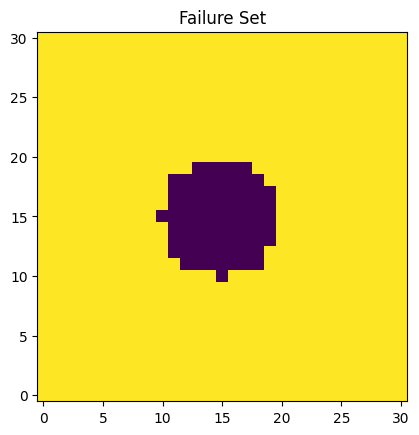

In [48]:
obstacle1 = jnp.linalg.norm(np.array([0.0, 0.0]) - grid.states[..., :2], axis=-1) - radius

plt.title("Failure Set")
plt.imshow(obstacle1[:, :, 0, -1].T > 0, origin='lower')
plt.show()

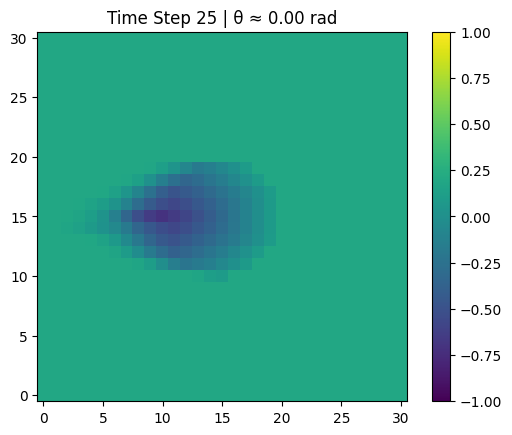

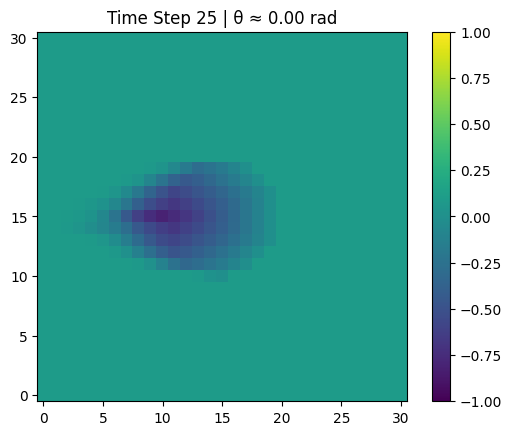

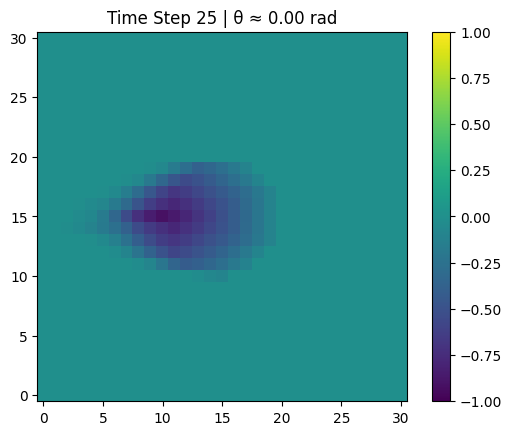

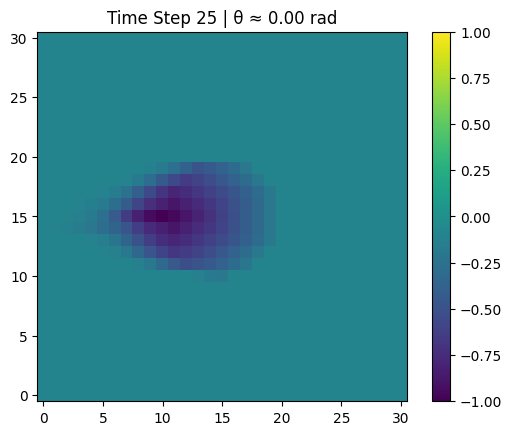

In [51]:
import matplotlib.colors as mcolors

# Define theta values
theta_values = jnp.linspace(0, 2 * jnp.pi, dim)

# Function to find the closest index for a given theta
def find_closest_index(value, values):
    return jnp.argmin(jnp.abs(values - value))

saved_slices = {}

# Loop through desired heat values
theta = 0.0
theta_index = find_closest_index(theta, theta_values)

heat_values = [0.6, 0.7, 0.8, 0.9]
norm = mcolors.Normalize(vmin=-1, vmax=1)        # same scale for every plot

for heat_value in heat_values:
    heat_idx = find_closest_index(heat_value, jnp.linspace(0, 1, dim))
    
    slice_data = np.array(target_values[-1, :, :, theta_index, heat_idx])
    # Store in dictionary with readable key
    key = f"theta_{theta:.4f}_rad"
    saved_slices[key] = slice_data
    # Visualize for time index 25
    unsafe = target_values[-1, :, :, theta_index, heat_idx]   # final slice
    im = plt.imshow(unsafe.T, origin='lower', norm=norm, cmap='viridis')
    plt.title(f"Time Step 25 | θ ≈ {theta_values[theta_index]:.2f} rad")
    plt.colorbar(im)
    plt.show()

np.savez(f"../gt_dubins/value_function_theta_heat_slices_{dim}.npz", **saved_slices)